In [16]:
import os
import torch
import joblib
import matplotlib


from mpp.utils.data_processing import DataProcessor
from mpp.utils.model_utils import train_and_evaluate_models
from mpp.models.neural_network import NeuralNetworkModel
from mpp.models.random_forest import RandomForestModel
from mpp.models.gradient_boosting import GradientBoostingModel
from mpp.models.knn import BaselineKNN
from mpp.utils.visualization import plot_correlation_matrix, plot_results, plot_training_process, plot_multiple_training_processes, plot_feature_correlations
from mpp.tuning.tune import HyperparameterTuning

import warnings
warnings.filterwarnings('ignore')

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
def model_exists(model_path):
    return os.path.exists(model_path)

In [13]:
# Load the data
processor = DataProcessor("data/data.csv")
data = processor.load_data()
data_with_features = processor.extract_features()
print(data_with_features)

       pIC50  num_atoms     logP    MolWt  NumAtoms  NumBonds  NumC  NumO  \
0       4.26         25  4.15910  367.455        25        28     0     2   
1       4.34         36  3.67430  506.434        36        40     2     4   
2       4.53         23  1.53610  317.389        23        25    10     3   
3       4.56         22  0.95100  301.394        22        24     9     1   
4       4.59         21  3.21300  294.383        21        23     2     0   
...      ...        ...      ...      ...       ...       ...   ...   ...   
15032   0.00         24  3.21560  333.420        24        26     2     0   
15033   0.00         19  5.45270  275.461        19        19    11     0   
15034   0.00         17  4.67250  247.407        17        17     9     0   
15035   0.00         22  3.93289  306.394        22        25     1     0   
15036   0.02         13  1.70887  181.131        13        13     2     2   

       NumN  NumCl  NumF  NumBr  NumI  
0         1      0     0      0    

In [17]:
# Split the data
X_train, X_test, y_train_pic50, y_test_pic50, y_train_logP, y_test_logP = processor.split_data()

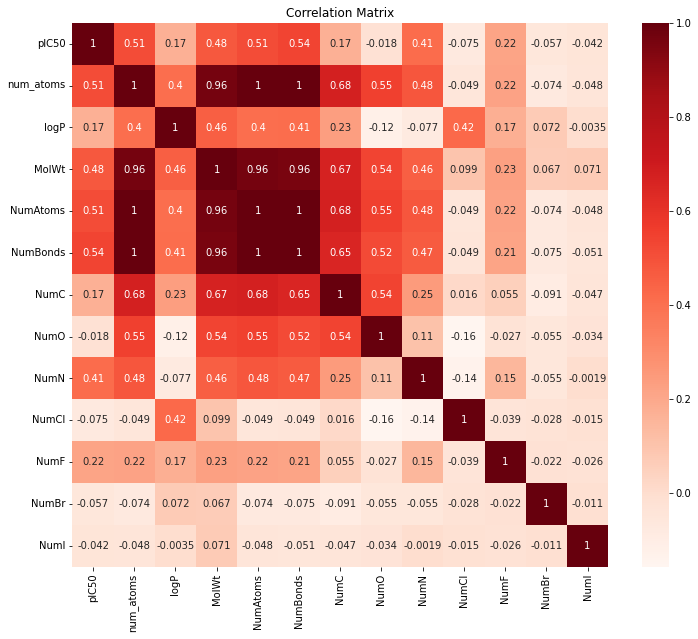

In [6]:
# Feature visualization
plot_correlation_matrix(data_with_features)

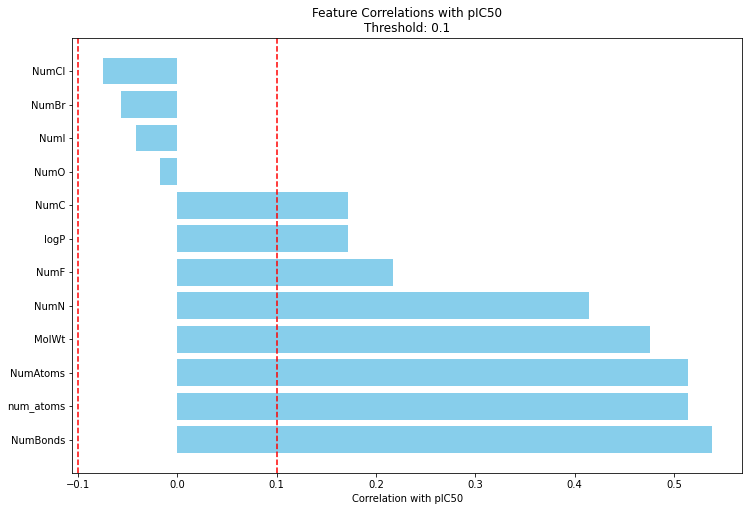

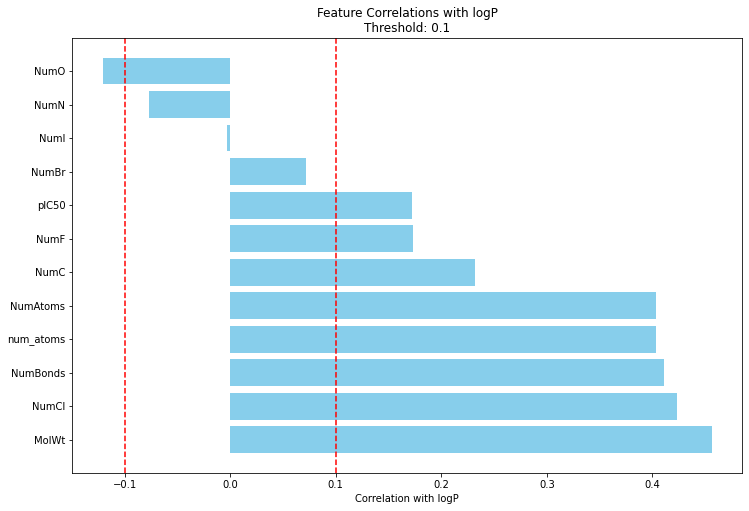

In [7]:
# Plot feature correlations with pIC50 and logP
plot_feature_correlations(data_with_features, 'pIC50', output_path="feature_correlations_pic50.png")
plot_feature_correlations(data_with_features, 'logP', output_path="feature_correlations_logP.png")

[I 2024-06-17 14:10:16,085] A new study created in memory with name: no-name-f3580c52-53dd-401c-bb6f-f3598e68dcf4


[I 2024-06-17 14:11:03,857] Trial 0 finished with value: 2.225941091191535 and parameters: {'lr': 2.140965983812187e-05, 'epochs': 26, 'batch_size': 48, 'hidden_layers': 3, 'hidden_size_0': 96, 'hidden_size_1': 198, 'hidden_size_2': 224, 'patience': 20}. Best is trial 0 with value: 2.225941091191535.


[I 2024-06-17 14:12:02,124] Trial 1 finished with value: 1.8931084369358264 and parameters: {'lr': 3.0659708562838075e-05, 'epochs': 70, 'batch_size': 128, 'hidden_layers': 3, 'hidden_size_0': 203, 'hidden_size_1': 60, 'hidden_size_2': 226, 'patience': 10}. Best is trial 1 with value: 1.8931084369358264.


[I 2024-06-17 14:12:24,941] Trial 2 finished with value: 1.407594682205291 and parameters: {'lr': 0.021600806489327617, 'epochs': 34, 'batch_size': 119, 'hidden_layers': 2, 'hidden_size_0': 176, 'hidden_size_1': 103, 'patience': 6}. Best is trial 2 with value: 1.407594682205291.


[I 2024-06-17 14:12:44,035] Trial 3 finished with value: 1.3454690001629017 and parameters: {'lr': 0.004355585704122474, 'epochs': 70, 'batch_size': 92, 'hidden_layers': 2, 'hidden_size_0': 44, 'hidden_size_1': 115, 'patience': 6}. Best is trial 3 with value: 1.3454690001629017.


[I 2024-06-17 14:12:54,466] Trial 4 finished with value: 1.854522618982527 and parameters: {'lr': 0.0035769130293012586, 'epochs': 16, 'batch_size': 54, 'hidden_layers': 1, 'hidden_size_0': 66, 'patience': 7}. Best is trial 3 with value: 1.3454690001629017.


[I 2024-06-17 14:14:06,094] Trial 5 finished with value: 2.2436121827171696 and parameters: {'lr': 0.00017933639814876154, 'epochs': 87, 'batch_size': 39, 'hidden_layers': 1, 'hidden_size_0': 32, 'patience': 19}. Best is trial 3 with value: 1.3454690001629017.


[I 2024-06-17 14:14:52,868] Trial 6 finished with value: 3.40422746172147 and parameters: {'lr': 1.0047201704826763e-05, 'epochs': 32, 'batch_size': 18, 'hidden_layers': 1, 'hidden_size_0': 75, 'patience': 5}. Best is trial 3 with value: 1.3454690001629017.


[I 2024-06-17 14:15:33,468] Trial 7 finished with value: 2.0964054465293884 and parameters: {'lr': 0.00024982228828087386, 'epochs': 73, 'batch_size': 68, 'hidden_layers': 1, 'hidden_size_0': 101, 'patience': 15}. Best is trial 3 with value: 1.3454690001629017.


[I 2024-06-17 14:17:31,799] Trial 8 finished with value: 1.3657191988479878 and parameters: {'lr': 0.005663859442797235, 'epochs': 92, 'batch_size': 43, 'hidden_layers': 2, 'hidden_size_0': 251, 'hidden_size_1': 214, 'patience': 17}. Best is trial 3 with value: 1.3454690001629017.


[I 2024-06-17 14:18:41,500] Trial 9 finished with value: 1.1860015663977077 and parameters: {'lr': 0.007782868579820504, 'epochs': 48, 'batch_size': 59, 'hidden_layers': 2, 'hidden_size_0': 256, 'hidden_size_1': 256, 'patience': 8}. Best is trial 9 with value: 1.1860015663977077.


[I 2024-06-17 14:19:19,351] Trial 10 finished with value: 2.696201640826005 and parameters: {'lr': 0.09945587586837118, 'epochs': 51, 'batch_size': 93, 'hidden_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 255, 'hidden_size_2': 32, 'patience': 11}. Best is trial 9 with value: 1.1860015663977077.


[I 2024-06-17 14:20:06,803] Trial 11 finished with value: 1.2526746447439547 and parameters: {'lr': 0.0013069423238857396, 'epochs': 53, 'batch_size': 92, 'hidden_layers': 2, 'hidden_size_0': 158, 'hidden_size_1': 138, 'patience': 9}. Best is trial 9 with value: 1.1860015663977077.


[I 2024-06-17 14:20:54,065] Trial 12 finished with value: 1.686648890376091 and parameters: {'lr': 0.0006413197416027127, 'epochs': 50, 'batch_size': 89, 'hidden_layers': 2, 'hidden_size_0': 167, 'hidden_size_1': 166, 'patience': 9}. Best is trial 9 with value: 1.1860015663977077.


[I 2024-06-17 14:21:42,723] Trial 13 finished with value: 1.1428565563577595 and parameters: {'lr': 0.0013550338321278285, 'epochs': 42, 'batch_size': 74, 'hidden_layers': 2, 'hidden_size_0': 211, 'hidden_size_1': 147, 'patience': 13}. Best is trial 13 with value: 1.1428565563577595.


[I 2024-06-17 14:22:35,794] Trial 14 finished with value: 1.2624094575643539 and parameters: {'lr': 0.021285976150430534, 'epochs': 40, 'batch_size': 70, 'hidden_layers': 2, 'hidden_size_0': 216, 'hidden_size_1': 250, 'patience': 13}. Best is trial 13 with value: 1.1428565563577595.


[I 2024-06-17 14:23:02,882] Trial 15 finished with value: 1.646575450186207 and parameters: {'lr': 0.016160005333141478, 'epochs': 12, 'batch_size': 26, 'hidden_layers': 3, 'hidden_size_0': 216, 'hidden_size_1': 35, 'hidden_size_2': 46, 'patience': 13}. Best is trial 13 with value: 1.1428565563577595.


[I 2024-06-17 14:24:21,698] Trial 16 finished with value: 1.1267062981681126 and parameters: {'lr': 0.0009657392635403195, 'epochs': 62, 'batch_size': 60, 'hidden_layers': 2, 'hidden_size_0': 235, 'hidden_size_1': 184, 'patience': 15}. Best is trial 16 with value: 1.1267062981681126.


[I 2024-06-17 14:25:39,258] Trial 17 finished with value: 1.2989039315331368 and parameters: {'lr': 0.001022289744564236, 'epochs': 63, 'batch_size': 80, 'hidden_layers': 3, 'hidden_size_0': 136, 'hidden_size_1': 166, 'hidden_size_2': 139, 'patience': 15}. Best is trial 16 with value: 1.1267062981681126.


[I 2024-06-17 14:26:48,845] Trial 18 finished with value: 1.5790308636167776 and parameters: {'lr': 0.00012136147270395094, 'epochs': 83, 'batch_size': 109, 'hidden_layers': 2, 'hidden_size_0': 188, 'hidden_size_1': 198, 'patience': 15}. Best is trial 16 with value: 1.1267062981681126.


[I 2024-06-17 14:27:47,206] Trial 19 finished with value: 1.7316235869358747 and parameters: {'lr': 0.00045117916393493665, 'epochs': 62, 'batch_size': 62, 'hidden_layers': 1, 'hidden_size_0': 227, 'patience': 17}. Best is trial 16 with value: 1.1267062981681126.


[I 2024-06-17 14:28:27,910] Trial 20 finished with value: 1.1471375017426908 and parameters: {'lr': 0.001952885490826852, 'epochs': 42, 'batch_size': 76, 'hidden_layers': 2, 'hidden_size_0': 145, 'hidden_size_1': 159, 'patience': 12}. Best is trial 16 with value: 1.1267062981681126.


[I 2024-06-17 14:29:07,304] Trial 21 finished with value: 1.043193900026381 and parameters: {'lr': 0.0019122672392732681, 'epochs': 42, 'batch_size': 76, 'hidden_layers': 2, 'hidden_size_0': 135, 'hidden_size_1': 156, 'patience': 12}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:29:30,069] Trial 22 finished with value: 1.240358254121196 and parameters: {'lr': 0.002218225156509281, 'epochs': 25, 'batch_size': 78, 'hidden_layers': 2, 'hidden_size_0': 109, 'hidden_size_1': 117, 'patience': 14}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:30:18,935] Trial 23 finished with value: 1.8599670976400375 and parameters: {'lr': 7.95537812212179e-05, 'epochs': 60, 'batch_size': 103, 'hidden_layers': 2, 'hidden_size_0': 128, 'hidden_size_1': 143, 'patience': 17}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:31:15,156] Trial 24 finished with value: 1.2875124116085077 and parameters: {'lr': 0.00048081732737821636, 'epochs': 41, 'batch_size': 64, 'hidden_layers': 2, 'hidden_size_0': 229, 'hidden_size_1': 185, 'patience': 11}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:33:10,447] Trial 25 finished with value: 1.2169634439561465 and parameters: {'lr': 0.010667855817086467, 'epochs': 100, 'batch_size': 33, 'hidden_layers': 2, 'hidden_size_0': 192, 'hidden_size_1': 221, 'patience': 12}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:33:55,256] Trial 26 finished with value: 1.5474163975980546 and parameters: {'lr': 0.0023099649145837974, 'epochs': 45, 'batch_size': 54, 'hidden_layers': 1, 'hidden_size_0': 235, 'patience': 14}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:34:54,702] Trial 27 finished with value: 1.1353575022056186 and parameters: {'lr': 0.0003189245781027182, 'epochs': 58, 'batch_size': 85, 'hidden_layers': 3, 'hidden_size_0': 118, 'hidden_size_1': 85, 'hidden_size_2': 135, 'patience': 16}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:36:09,650] Trial 28 finished with value: 1.133109905596437 and parameters: {'lr': 0.0002931475366592465, 'epochs': 77, 'batch_size': 85, 'hidden_layers': 3, 'hidden_size_0': 121, 'hidden_size_1': 90, 'hidden_size_2': 137, 'patience': 18}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:37:08,592] Trial 29 finished with value: 1.8879342377185822 and parameters: {'lr': 4.5542743786285877e-05, 'epochs': 77, 'batch_size': 104, 'hidden_layers': 3, 'hidden_size_0': 89, 'hidden_size_1': 73, 'hidden_size_2': 94, 'patience': 20}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:38:56,604] Trial 30 finished with value: 1.0918175696202044 and parameters: {'lr': 0.0008089101431981908, 'epochs': 79, 'batch_size': 46, 'hidden_layers': 3, 'hidden_size_0': 150, 'hidden_size_1': 182, 'hidden_size_2': 192, 'patience': 19}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:41:04,811] Trial 31 finished with value: 1.168684355628032 and parameters: {'lr': 0.0004885175053732441, 'epochs': 66, 'batch_size': 47, 'hidden_layers': 3, 'hidden_size_0': 149, 'hidden_size_1': 181, 'hidden_size_2': 184, 'patience': 19}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:42:52,380] Trial 32 finished with value: 1.1338870398079355 and parameters: {'lr': 0.0008039310042963296, 'epochs': 78, 'batch_size': 51, 'hidden_layers': 3, 'hidden_size_0': 122, 'hidden_size_1': 125, 'hidden_size_2': 180, 'patience': 18}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:46:02,944] Trial 33 finished with value: 1.1276654759004934 and parameters: {'lr': 0.00014457972579039226, 'epochs': 81, 'batch_size': 36, 'hidden_layers': 3, 'hidden_size_0': 170, 'hidden_size_1': 222, 'hidden_size_2': 186, 'patience': 20}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:49:30,066] Trial 34 finished with value: 1.1362110254903361 and parameters: {'lr': 7.839812352496579e-05, 'epochs': 92, 'batch_size': 33, 'hidden_layers': 3, 'hidden_size_0': 174, 'hidden_size_1': 220, 'hidden_size_2': 188, 'patience': 20}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:51:59,178] Trial 35 finished with value: 1.632741160533378 and parameters: {'lr': 1.9399142363340648e-05, 'epochs': 69, 'batch_size': 34, 'hidden_layers': 3, 'hidden_size_0': 196, 'hidden_size_1': 185, 'hidden_size_2': 253, 'patience': 19}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 14:57:21,520] Trial 36 finished with value: 1.1166197509341633 and parameters: {'lr': 0.0038870893465476185, 'epochs': 85, 'batch_size': 25, 'hidden_layers': 3, 'hidden_size_0': 153, 'hidden_size_1': 201, 'hidden_size_2': 207, 'patience': 20}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:03:25,732] Trial 37 finished with value: 1.185689027365667 and parameters: {'lr': 0.004236567213649325, 'epochs': 88, 'batch_size': 16, 'hidden_layers': 3, 'hidden_size_0': 154, 'hidden_size_1': 202, 'hidden_size_2': 221, 'patience': 18}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:04:21,119] Trial 38 finished with value: 6.291783284756445 and parameters: {'lr': 0.03908683155729866, 'epochs': 31, 'batch_size': 26, 'hidden_layers': 2, 'hidden_size_0': 136, 'hidden_size_1': 172, 'patience': 16}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:06:10,461] Trial 39 finished with value: 1.1335197269956592 and parameters: {'lr': 0.0023878866641461314, 'epochs': 72, 'batch_size': 26, 'hidden_layers': 2, 'hidden_size_0': 65, 'hidden_size_1': 202, 'patience': 11}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:07:14,925] Trial 40 finished with value: 1.260332270683545 and parameters: {'lr': 0.006693189941405358, 'epochs': 98, 'batch_size': 46, 'hidden_layers': 2, 'hidden_size_0': 88, 'hidden_size_1': 150, 'patience': 16}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:09:25,473] Trial 41 finished with value: 1.3108448035180056 and parameters: {'lr': 0.003302050180005661, 'epochs': 83, 'batch_size': 42, 'hidden_layers': 3, 'hidden_size_0': 179, 'hidden_size_1': 235, 'hidden_size_2': 178, 'patience': 20}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:11:25,952] Trial 42 finished with value: 1.0928210020065308 and parameters: {'lr': 0.00017338319675292584, 'epochs': 82, 'batch_size': 58, 'hidden_layers': 3, 'hidden_size_0': 165, 'hidden_size_1': 234, 'hidden_size_2': 206, 'patience': 19}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:13:42,040] Trial 43 finished with value: 1.0914830766444983 and parameters: {'lr': 0.0009709155122722126, 'epochs': 91, 'batch_size': 56, 'hidden_layers': 3, 'hidden_size_0': 161, 'hidden_size_1': 235, 'hidden_size_2': 212, 'patience': 19}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:15:51,576] Trial 44 finished with value: 1.0935451253740625 and parameters: {'lr': 0.001383250101505909, 'epochs': 93, 'batch_size': 55, 'hidden_layers': 3, 'hidden_size_0': 161, 'hidden_size_1': 233, 'hidden_size_2': 212, 'patience': 19}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:17:50,410] Trial 45 finished with value: 1.3088915626207986 and parameters: {'lr': 0.0015844645740314847, 'epochs': 94, 'batch_size': 54, 'hidden_layers': 3, 'hidden_size_0': 163, 'hidden_size_1': 238, 'hidden_size_2': 254, 'patience': 19}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:19:54,136] Trial 46 finished with value: 1.1774267069129056 and parameters: {'lr': 0.00024286792726484327, 'epochs': 91, 'batch_size': 56, 'hidden_layers': 3, 'hidden_size_0': 140, 'hidden_size_1': 241, 'hidden_size_2': 208, 'patience': 18}. Best is trial 21 with value: 1.043193900026381.


[I 2024-06-17 15:21:58,146] Trial 47 finished with value: 1.0314259965800576 and parameters: {'lr': 0.0006466106622077833, 'epochs': 97, 'batch_size': 67, 'hidden_layers': 3, 'hidden_size_0': 180, 'hidden_size_1': 231, 'hidden_size_2': 158, 'patience': 19}. Best is trial 47 with value: 1.0314259965800576.


[I 2024-06-17 15:24:08,093] Trial 48 finished with value: 1.111316113153825 and parameters: {'lr': 0.00018590563442610238, 'epochs': 98, 'batch_size': 66, 'hidden_layers': 3, 'hidden_size_0': 183, 'hidden_size_1': 212, 'hidden_size_2': 168, 'patience': 17}. Best is trial 47 with value: 1.0314259965800576.


[I 2024-06-17 15:25:47,970] Trial 49 finished with value: 1.1858865201473237 and parameters: {'lr': 0.0006360670960248416, 'epochs': 96, 'batch_size': 69, 'hidden_layers': 3, 'hidden_size_0': 202, 'hidden_size_1': 251, 'hidden_size_2': 153, 'patience': 19}. Best is trial 47 with value: 1.0314259965800576.




Best trial for Neural Network: {'lr': 0.0006466106622077833, 'epochs': 97, 'batch_size': 67, 'hidden_layers': 3, 'hidden_size_0': 180, 'hidden_size_1': 231, 'hidden_size_2': 158, 'patience': 19}



Neural Network Model MSE for pIC50: 0.8334417409468946


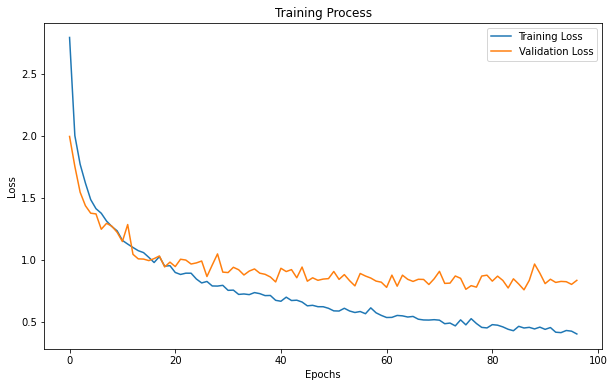

In [18]:
# Hyperparameter tuning for Neural Network (pIC50)
if model_exists('params/nn_best_params_pic50.pkl'):
    print("Loaded existing pIC50 params.")
    loaded_best_params_pic50 = joblib.load('params/nn_best_params_pic50.pkl')
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_pic50[f"hidden_size_{i}"] for i in range(loaded_best_params_pic50["hidden_layers"])],
        lr=best_params_pic50["lr"],
        epochs=best_params_pic50["epochs"],
        batch_size=best_params_pic50["batch_size"],
        patience=best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    torch.save(nn_model_pic50.model.state_dict(), 'models/nn_model_pic50.pth')
    print(f"Neural Network Model MSE for pIC50: {nn_model_pic50.evaluate(X_test, y_test_pic50)}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")
else:
    tuner_pic50 = HyperparameterTuning(X_train, y_train_pic50, "Neural Network")
    best_params_pic50 = tuner_pic50.tune(n_trials=50)
    joblib.dump(best_params_pic50, 'params/nn_best_params_pic50.pkl')
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_pic50[f"hidden_size_{i}"] for i in range(best_params_pic50["hidden_layers"])],
        lr=best_params_pic50["lr"],
        epochs=best_params_pic50["epochs"],
        batch_size=best_params_pic50["batch_size"],
        patience=best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    torch.save(nn_model_pic50.model.state_dict(), 'models/nn_model_pic50.pth')
    print(f"Neural Network Model MSE for pIC50: {nn_model_pic50.evaluate(X_test, y_test_pic50)}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")


In [21]:
if model_exists('models/nn_model_pic50.pth'):
    nn_model_pic50 = NeuralNetworkModel(input_size=X_train.shape[1], hidden_sizes=[64, 32])  # Initialize with dummy sizes
    nn_model_pic50.load_model('models/nn_model_pic50.pth')
    print("Loaded existing pIC50 model.")

RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	Unexpected key(s) in state_dict: "network.6.weight", "network.6.bias". 
	size mismatch for network.0.weight: copying a param with shape torch.Size([180, 11]) from checkpoint, the shape in current model is torch.Size([64, 11]).
	size mismatch for network.0.bias: copying a param with shape torch.Size([180]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for network.2.weight: copying a param with shape torch.Size([231, 180]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for network.2.bias: copying a param with shape torch.Size([231]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for network.4.weight: copying a param with shape torch.Size([158, 231]) from checkpoint, the shape in current model is torch.Size([1, 32]).
	size mismatch for network.4.bias: copying a param with shape torch.Size([158]) from checkpoint, the shape in current model is torch.Size([1]).

In [19]:
# Hyperparameter tuning for Neural Network (logP)
if model_exists('models/nn_model_logP.pth'):
    nn_model_logP = NeuralNetworkModel(input_size=X_train.shape[1], hidden_sizes=[64, 32])  # Initialize with dummy sizes
    nn_model_logP.load_model('models/nn_model_logP.pth')
    print("Loaded existing logP model.")
else:
    tuner_logP = HyperparameterTuning(X_train, y_train_logP, "Neural Network")
    best_params_logP = tuner_logP.tune(n_trials=50)
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_logP[f"hidden_size_{i}"] for i in range(best_params_logP["hidden_layers"])],
        lr=best_params_logP["lr"],
        epochs=best_params_logP["epochs"],
        batch_size=best_params_logP["batch_size"],
        patience=best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    torch.save(nn_model_logP.model.state_dict(), 'models/nn_model_logP.pth')
    print(f"Neural Network Model MSE for logP: {nn_model_logP.evaluate(X_test, y_test_logP)}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")


RuntimeError: Error(s) in loading state_dict for NeuralNetwork:
	Unexpected key(s) in state_dict: "network.6.weight", "network.6.bias". 
	size mismatch for network.0.weight: copying a param with shape torch.Size([130, 11]) from checkpoint, the shape in current model is torch.Size([64, 11]).
	size mismatch for network.0.bias: copying a param with shape torch.Size([130]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for network.2.weight: copying a param with shape torch.Size([146, 130]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for network.2.bias: copying a param with shape torch.Size([146]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for network.4.weight: copying a param with shape torch.Size([160, 146]) from checkpoint, the shape in current model is torch.Size([1, 32]).
	size mismatch for network.4.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([1]).

In [9]:
# Hyperparameter tuning and model training for KNN (pIC50)
if model_exists('models/knn_model_pic50.pkl'):
    knn_model_pic50 = joblib.load('models/knn_model_pic50.pkl')
    print("Loaded existing pIC50 KNN model.")
else:
    tuner_pic50_knn = HyperparameterTuning(X_train, y_train_pic50, "KNN")
    best_params_pic50_knn = tuner_pic50_knn.tune(n_trials=50)
    knn_model_pic50 = BaselineKNN(n_neighbors=best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(knn_model_pic50, 'models/knn_model_pic50.pkl')
    print(f"KNN Model MSE for pIC50: {knn_model_pic50.evaluate(X_test, y_test_pic50)}")


Loaded existing pIC50 KNN model.


In [11]:
# Hyperparameter tuning and model training for KNN (logP)
if model_exists('models/knn_model_logP.pkl'):
    knn_model_logP = joblib.load('models/knn_model_logP.pkl')
    print("Loaded existing logP KNN model.")
else:
    tuner_logP_knn = HyperparameterTuning(X_train, y_train_logP, "KNN")
    best_params_logP_knn = tuner_logP_knn.tune(n_trials=50)
    knn_model_logP = BaselineKNN(n_neighbors=best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    joblib.dump(knn_model_logP, 'models/knn_model_logP.pkl')
    print(f"KNN Model MSE for logP: {knn_model_logP.evaluate(X_test, y_test_logP)}")

[I 2024-06-05 17:19:40,923] A new study created in memory with name: no-name-56c1dc46-2bd6-41b1-b5f1-03f6a85cd989


Hyperparameter Tuning (KNN):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:19:41,007] Trial 0 finished with value: 1.1126155153514925 and parameters: {'n_neighbors': 1}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,127] Trial 1 finished with value: 1.1546031506048549 and parameters: {'n_neighbors': 21}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,255] Trial 2 finished with value: 1.2276263546305721 and parameters: {'n_neighbors': 29}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,369] Trial 3 finished with value: 1.144449723224965 and parameters: {'n_neighbors': 20}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,478] Trial 4 finished with value: 0.97212624252438 and parameters: {'n_neighbors': 2}. Best is trial 4 with value: 0.97212624252438.
[I 2024-06-05 17:19:41,581] Trial 5 finished with value: 0.9934813214859163 and parameters: {'n_neighbors': 9}. Best is trial 4 with value: 0.97212624252438.
[I 2024-06-05 17:19:41,669] Trial 6 finished

Best trial for KNN: {'n_neighbors': 4}
KNN Model MSE for logP: 0.7275619698566268


In [10]:
# Hyperparameter tuning and model training for Random Forest (pIC50)
if model_exists('models/rf_model_pic50.pkl'):
    rf_model_pic50 = joblib.load('models/rf_model_pic50.pkl')
    print("Loaded existing pIC50 Random Forest model.")
else:
    tuner_pic50_rf = HyperparameterTuning(X_train, y_train_pic50, "Random Forest")
    best_params_pic50_rf = tuner_pic50_rf.tune(n_trials=50)
    rf_model_pic50 = RandomForestModel(n_estimators=best_params_pic50_rf["n_estimators"], max_depth=best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(rf_model_pic50, 'models/rf_model_pic50.pkl')
    print(f"Random Forest Model MSE for pIC50: {rf_model_pic50.evaluate(X_test, y_test_pic50)}")


Loaded existing pIC50 Random Forest model.


In [11]:
# Hyperparameter tuning and model training for Random Forest (logP)
if model_exists('models/rf_model_logP.pkl'):
    rf_model_logP = joblib.load('models/rf_model_logP.pkl')
    print("Loaded existing logP Random Forest model.")
else:
    tuner_logP_rf = HyperparameterTuning(X_train, y_train_logP, "Random Forest")
    best_params_logP_rf = tuner_logP_rf.tune(n_trials=50)
    rf_model_logP = RandomForestModel(n_estimators=best_params_logP_rf["n_estimators"], max_depth=best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    joblib.dump(rf_model_logP, 'models/rf_model_logP.pkl')
    print(f"Random Forest Model MSE for logP: {rf_model_logP.evaluate(X_test, y_test_logP)}")


Loaded existing logP Random Forest model.


In [26]:
# Hyperparameter tuning and model training for Gradient Boosting (pIC50)
if model_exists('models/gb_model_pic50.pkl'):
    gb_model_pic50 = joblib.load('models/gb_model_pic50.pkl')
    print("Loaded existing pIC50 Gradient Boosting model.")
else:
    tuner_pic50_gb = HyperparameterTuning(X_train, y_train_pic50, "Gradient Boosting")
    best_params_pic50_gb = tuner_pic50_gb.tune(n_trials=50)
    gb_model_pic50 = GradientBoostingModel(n_estimators=best_params_pic50_gb["n_estimators"], learning_rate=best_params_pic50_gb["learning_rate"], max_depth=best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(gb_model_pic50, 'models/gb_model_pic50.pkl')
    print(f"Gradient Boosting Model MSE for pIC50: {gb_model_pic50.evaluate(X_test, y_test_pic50)}")


[I 2024-06-05 17:46:31,067] A new study created in memory with name: no-name-c0401a11-51c2-4729-991e-bf1dd22c9893


Hyperparameter Tuning (Gradient Boosting):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:46:41,844] Trial 0 finished with value: 1.9741623309396343 and parameters: {'n_estimators': 170, 'learning_rate': 0.015455488347100876, 'max_depth': 17}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:46:54,672] Trial 1 finished with value: 2.1601913554817034 and parameters: {'n_estimators': 190, 'learning_rate': 0.03570346591583864, 'max_depth': 22}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:03,749] Trial 2 finished with value: 4.294957272258382 and parameters: {'n_estimators': 136, 'learning_rate': 0.0017518093655901003, 'max_depth': 24}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:12,409] Trial 3 finished with value: 2.143069195163415 and parameters: {'n_estimators': 127, 'learning_rate': 0.03441006957915809, 'max_depth': 31}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:23,856] Trial 4 finished with value: 4.4924478324350705 and parameters: {'n_estimators': 166, 'learning_rat

Best trial for Gradient Boosting: {'n_estimators': 172, 'learning_rate': 0.05435332478136519, 'max_depth': 7}
Gradient Boosting Model MSE for pIC50: 1.0590004873622547


In [12]:
# Hyperparameter tuning and model training for Gradient Boosting (logP)
if model_exists('models/gb_model_logP.pkl'):
    gb_model_logP = joblib.load('models/gb_model_logP.pkl')
    print("Loaded existing logP Gradient Boosting model.")
else:
    tuner_logP_gb = HyperparameterTuning(X_train, y_train_logP, "Gradient Boosting")
    best_params_logP_gb = tuner_logP_gb.tune(n_trials=50)
    gb_model_logP = GradientBoostingModel(n_estimators=best_params_logP_gb["n_estimators"], learning_rate=best_params_logP_gb["learning_rate"], max_depth=best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    joblib.dump(gb_model_logP, 'models/gb_model_logP.pkl')
    print(f"Gradient Boosting Model MSE for logP: {gb_model_logP.evaluate(X_test, y_test_logP)}")


ModuleNotFoundError: No module named '_loss'

In [28]:
# Results visualization for pIC50
results_pic50 = {
    "Neural Network": nn_model_pic50.evaluate(X_test, y_test_pic50),
    "KNN": knn_model_pic50.evaluate(X_test, y_test_pic50),
    "Random Forest": rf_model_pic50.evaluate(X_test, y_test_pic50),
    "Gradient Boosting": gb_model_pic50.evaluate(X_test, y_test_pic50)
}

In [29]:
# Results visualization for logP
results_logP = {
    "Neural Network": nn_model_logP.evaluate(X_test, y_test_logP),
    "KNN": knn_model_logP.evaluate(X_test, y_test_logP),
    "Random Forest": rf_model_logP.evaluate(X_test, y_test_logP),
    "Gradient Boosting": gb_model_logP.evaluate(X_test, y_test_logP)
}

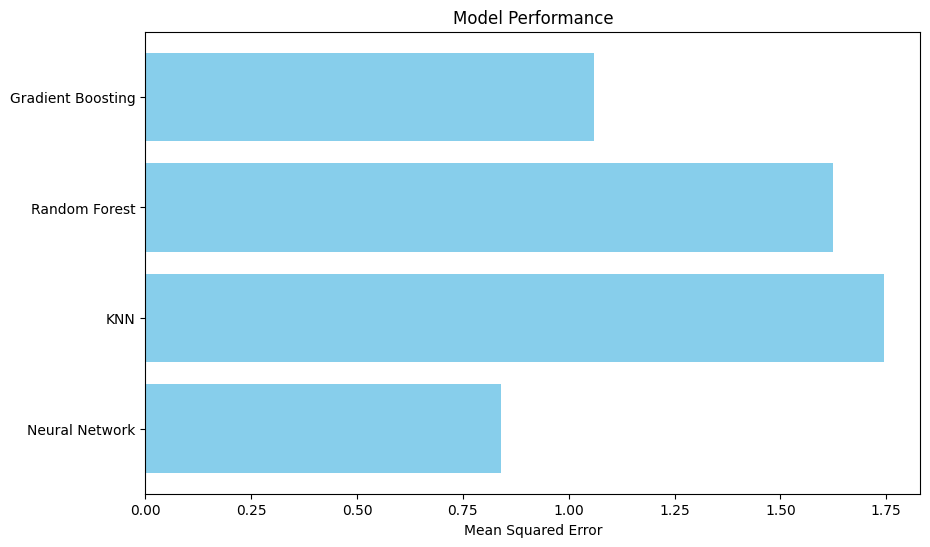

In [30]:
# Results visualization for pIC50
plot_results(results_pic50)

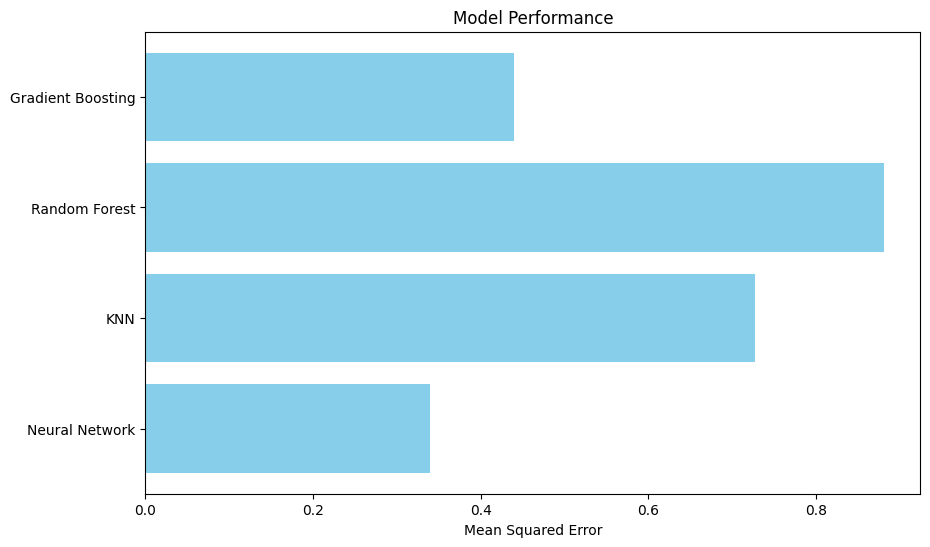

In [31]:
# Results visualization for logP
plot_results(results_logP)

In [33]:
# Visualize training processes for all models (pIC50)
# plot_multiple_training_processes(training_losses_pic50, validation_losses_pic50)


In [34]:
# Visualize training processes for all models (logP)
# plot_multiple_training_processes(training_losses_logP, validation_losses_logP)
